In [31]:
import numpy as np
# import cv2
import os
import random
import scipy.misc as scm

import cv2
import tensorflow as tf
import scipy
class DataGenerator():
    def __init__(self, imgdir=None, txt=None,  resize=256, hmsize=64,scale=0.25,normalize=True,flipping=False,color_jitting=30,

                 rotate=30, batch_size=32,  is_aug=True,randomize=True,joints_name=None,datasetname="train",isTraing=True,
                 pixel_mean = np.array([[[102.9801,115.9465,122.7717]]])):


        self.joints_name = joints_name
        self.letter = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']
        self.img_dir = imgdir
        self.train_data_file = txt
        self.images = os.listdir(imgdir)
        self.israndom = randomize
        self.name = datasetname
        self.normalize = normalize
        self.batch_size = batch_size
        self.joints_name = joints_name

        self.is_aug = is_aug
        self.partnum = len(self.joints_name)

        self.resize = [resize,resize]
        self.res = [hmsize,hmsize]
        self.isTrainging = isTraing

        self.pixel_means = pixel_mean
        self.sym = [(0,3),(1,4),(2,5),(6,9),(7,10),(8,11)]
        self.creatset()

    def load_data(self):
        self.train_table = []
        self.no_intel = []
        self.data_dict = {}
        input_file = open(self.train_data_file, 'r')
        print('READING TRAIN DATA')
        for line in input_file:
            line = line.strip()
            line = line.split(' ')
            name = line[0]
            box = list(map(int, line[1:5]))
            joints = np.array(list(map(int, line[5:])))

            joints = np.reshape(joints, (-1, 3))
            
            w = [1] * joints.shape[0]
            for i in range(joints.shape[0]):
                if np.array_equal(joints[i, :2], [0, 0] or np.array_equal(joints[i, 2], 3)):
                    w[i] = 0
                elif np.array_equal(joints[i, 2], 2):
                    w[i] = 2
            self.data_dict[name] = {'box': box, 'joints': joints, 'weights': w}
            self.train_table.append(name)
        input_file.close()

    def _randomize(self):
        """ Randomize the set
        """
        random.shuffle(self.train_table)

    def creatset(self):
        self.load_data()
        if self.israndom:
            self._randomize()
        self.dataset = self.train_table
        print('SET CREATED')
        np.save('Dataset% s'%self.name, self.dataset)
        print('--Training set :', len(self.dataset), ' samples.')

    def open_img(self, name, color='RGB'):
        """ Open an image
        Args:
            name	: Name of the sample
            color	: Color Mode (RGB/BGR/GRAY)
        """
        if name[-1] in self.letter:
            name = name[:-1]

        img_name =os.path.join(self.img_dir, name)
        img = scipy.misc.imread(img_name)
        return img

    def get_transform(self,center, scale, res, rot=0):
        '''
           进行坐标转换，获取转换矩阵
           '''
        # Generate transformation matrix
        h = scale
        t = np.zeros((3, 3))
        t[0, 0] = float(res[1]) / (h[1])
        t[1, 1] = float(res[0]) / (h[0])
        t[0, 2] = res[1] * (-float(center[0]) / h[1] + .5)
        t[1, 2] = res[0] * (-float(center[1]) / h[0] + .5)
        t[2, 2] = 1
        return t
    def getN(self):
        return len(self.dataset)

    def transform(self,pt, center, scale, res, invert=0, rot=0):
        '''
            进行坐标转换
            '''
        # Transform pixel location to different reference
        t = self.get_transform(center, scale, res, rot=rot)
        if invert:
            t = np.linalg.inv(t)
        new_pt = np.array([pt[0], pt[1], 1.]).T
        new_pt = np.dot(t, new_pt)
        return new_pt[:2].astype(int)

    def transformPreds(self,coords, center, scale, res, reverse=0):
        '''
        从预测坐标获得原图坐标，使用transform逆运算
        '''
        #     local origDims = coords:size()
        #     coords = coords:view(-1,2)
        lst = []

        for i in range(coords.shape[0]):
            lst.append(self.transform(coords[i], center, scale, res, reverse, 0, ))

        newCoords = np.stack(lst, axis=0)

        return newCoords

    def crop(self,img, center, scale, res):

        ul = np.array(self.transform([0, 0], center, scale, res, invert=1))

        br = np.array(self.transform(res, center, scale, res, invert=1))

        old_x = max(0, ul[0]), min(len(img[0]), br[0])
        old_y = max(0, ul[1]), min(len(img), br[1])
        new_img = img[old_y[0]:old_y[1], old_x[0]:old_x[1]]

        return scipy.misc.imresize(new_img, res)
    def getFeature(self, box):
        x1,y1,x2,y2 = box
        center = np.array(((x1 + x2) * 0.5, (y1 + y2) * 0.5))
        scale = y2 - y1, x2 - x1
        return center, scale


    def flip_data(self,img,miniimg, annot):
        n = annot.shape[0]
        newimg = cv2.flip(img, 1)
        new_mini = cv2.flip(miniimg, 1)

        width = newimg.shape[1]
        height = newimg.shape[0]
        cod = [];
        for i in range(n):
            x, y = annot[i][0], annot[i][1]
            if x >= 0:
                x = width - 1 - x
            cod.append((x, y))
        # threshold judgment，if overflow,set to -1
        for (q,w) in self.sym:
            cod[q],cod[w] = cod[w],cod[q]
        res = np.vstack(cod)
        for i in range(0, res.shape[0]):
            if res[i, 0] > width or res[i, 1] > height or res[i, 0] < 0 or res[i, 1] < 0:
                res[i, 0] = -1
                res[i, 1] = -1
        return newimg, new_mini,res

    def rotImg(self,img,mini, annot):
        height, width = img.shape[0], img.shape[1]

        mini_height,mini_width = mini.shape[0],mini.shape[1]
        minicenter = mini_width // 2, mini_height // 2

        center = width // 2, height // 2
        angle = random.uniform(0, 45)
        if random.randint(0, 1):
            angle *= -1
        rotMat = cv2.getRotationMatrix2D(center, angle, 1.0)
        newimg = cv2.warpAffine(img, rotMat, (width, height))

        minirotmat = cv2.getRotationMatrix2D(minicenter, angle, 1.0)
        newmini = cv2.warpAffine(mini, minirotmat, (mini_width, mini_height))
        allc = []

        for i in range(annot.shape[0]):
            x, y = annot[i][0], annot[i][1]
            coor = np.array([x, y])

            if x >= 0 and y >= 0:
                R = rotMat[:, : 2]
                W = np.array([rotMat[0][2], rotMat[1][2]])
                coor = np.dot(R, coor) + W
            allc.append(coor)
        res = np.vstack(allc)
        # threshold judgment，if overflow,set to -1
        for i in range(0, res.shape[0]):
            if res[i, 0] >= width or res[i, 1] >= height or res[i, 0] <= 0 or res[i, 1] <= 0:
                res[i, 0] = -1
                res[i, 1] = -1
        return newimg,newmini, res


    def recoverFromHm(self, hm,center,scale):
        '''
        从heatmap中获取原始输出
        :param hm:
        :param center:
        :param scale:
        :return:
        '''
        res = []
        for nbatch in range(hm.shape[0]):
            tmp_lst = []
            for i in range(hm.shape[-1]):
                index = np.unravel_index(hm[nbatch, :, :, i].argmax(), self.res)
                tmp_lst.append(index[::-1])
            res.append(self.transformPreds(np.stack(tmp_lst), center[nbatch], scale[nbatch], self.res, reverse=1))
        return np.stack(res)


    def generateHeatMap(self, center, scale, height, width, joints, maxlenght, weight):

        """ Generate a full Heap Map for every joints in an array

        Args:
            height			: Wanted Height for the Heat Map
            width			: Wanted Width for the Heat Map
            joints			: Array of Joints
            maxlenght		: Lenght of the Bounding Box
        """

        #joints = self.transformPreds(joints, center=center, scale=scale, res=[height, width])
        joints = np.divide(joints,4).astype(int)
        num_joints = joints.shape[0]
        hm = np.zeros((height, width ,num_joints), dtype=np.float32)
        for i in range(num_joints):
            if joints[i][0] <= 0 or joints[i][1] <= 0 or joints[i][0] >= height or joints[i][1] >= width:
                continue
            else:
                joints[i, 0] = min(joints[i,0], self.resize[0] - 1)
                joints[i, 1] = min(joints[i, 1], self.resize[1] - 1)

                hm[joints[i,1], joints[i,0],i ] = 1 #?????????????
        for i in range(num_joints):
            if weight[i] == 1:
                hm[:,:,i] = cv2.GaussianBlur(hm[:,:,i],(7,7),0)
            elif  weight[i] == 2:
                print("{} unseeee ".format(i))
                hm[:, :, i] = cv2.GaussianBlur(hm[:, :, i], (15, 15), 0)
        for i in range(num_joints):
            am = np.amax(hm[:,:,i])
            if am <= 1e-8:
                continue
            hm[:,:,i] /= am / 255

        return hm

    def TensorflowBatch(self):
        '''
        通过get_batch_generator获取tensorflow需要的batch
        :return:
        '''
        if self.isTrainging:
            #train_img,train_mini, train_gtmap,
            ds = tf.data.Dataset.from_generator(
                self.get_batch_generator, (tf.float32, tf.float32, tf.float32,),(tf.TensorShape([256,256,3]),
                                                                                 tf.TensorShape([64,64,3]),
                                                                                 tf.TensorShape([64, 64, 14])
                                                                                 ) )
            ds = ds.batch(self.batch_size)
            return ds.make_one_shot_iterator().get_next()

    def get_batch_generator(self):
        if self.isTrainging:
            while True:
                name = random.choice(self.dataset)

                joints = self.data_dict[name]['joints']

                box = self.data_dict[name]['box']

                center,scale = self.getFeature(box)
                weight = np.asarray(self.data_dict[name]['weights'])
                # train_weights[i] = weight
                img = self.open_img(name)
                crop_img = self.crop(img, center, scale, self.resize)
                train_mini = cv2.resize(crop_img,(64,64))


                crop_coord =  self.transformPreds(joints, center=center, scale=scale, res=self.resize)

                rand = random.randint(0, 4)
                if rand == 0:
                    continue
                elif rand == 1:

                    crop_img, train_mini,crop_coord = self.flip_data(crop_img,train_mini, crop_coord)
                elif rand == 2 or rand == 3:
                    crop_img,train_mini, crop_coord = self.rotImg(crop_img,train_mini, crop_coord)


                hm = self.generateHeatMap(center, scale, 64, 64, crop_coord, 64, weight)


                crop_img = (crop_img.astype(np.float64) - self.pixel_means)
                train_mini = (train_mini.astype(np.float64) - self.pixel_means)

                if self.normalize:
                    train_img = crop_img.astype(np.float32) / 255
                    train_mini = train_mini.astype(np.float32) / 255

                else:

                    train_img = crop_img.astype(np.float32)
                    train_mini = train_mini.astype(np.float32)
                train_gtmap = hm

                yield train_img,train_mini, train_gtmap,
        else:
            while True:
                train_img = np.zeros((self.batch_size, 256, 256, 3), dtype=np.float32)
                train_gtmap = np.zeros((self.batch_size, 64, 64, len(self.joints_name)), np.float32)
                train_weights = np.zeros((self.batch_size, len(self.joints_name)), np.float32)
                train_name = [None] * self.batch_size
                train_center = [None] * self.batch_size
                train_scale = [None] * self.batch_size
                i = 0
                while i < self.batch_size:
                    # try:

                    name = random.choice(self.dataset)

                    joints = self.data_dict[name]['joints']

                    box = self.data_dict[name]['box']
                    center, scale = self.getFeature(box)
                    weight = np.asarray(self.data_dict[name]['weights'])
                    # train_weights[i] = weight
                    img = self.open_img(name)
                    crop_img = self.crop(img, center, scale, self.resize)
                    train_mini = cv2.resize(crop_img, (64, 64))

                    crop_coord = self.transformPreds(joints, center=center, scale=scale, res=self.resize)
                    rand = random.randint(0, 4)

                    hm = self.generateHeatMap(center, scale, 64, 64, crop_coord, 64, weight)

                    # if self.is_aug:
                    #     crop_img, train_mini, hm = self.augment(crop_img,train_mini,hm)

                    crop_img = (crop_img.astype(np.float64) - self.pixel_means)


                    ##still need augment
                    if self.normalize:
                        train_img[i] = crop_img.astype(np.float32) / 255


                    else:

                        train_img[i] = crop_img.astype(np.float32)


                    train_gtmap[i] = hm
                    i = i + 1
                    # except:
                    #     print('error file: ', name)
                yield train_img, train_gtmap.astype(np.float32),  #train_name, train_center, train_scale



In [32]:
import configparser
def process_config(conf_file):
    '''
    从config文件中读取配置
    :param conf_file:
    :return:
    '''
    params = {}
    config = configparser.ConfigParser()
    config.read(conf_file)
    for section in config.sections():
        if section == 'DataSetHG':
            for option in config.options(section):
                params[option] = eval(config.get(section, option))
        if section == 'log':
            for option in config.options(section):
                params[option] = eval(config.get(section, option))
        if section == 'Saver':
            for option in config.options(section):
                params[option] = eval(config.get(section, option))
        if section == 'Training setting':
            for option in config.options(section):
                params[option] = eval(config.get(section, option))
    return params
params = process_config('../config/config_2.cfg')

In [33]:
    train_data = DataGenerator(imgdir=params["train_img_path"], txt="/media/bnrc2/_backup/dataset/aiclg/train_with_no_see.txt",
                               batch_size=1, is_aug=False,
                               joints_name=
                               params["joints"])

READING TRAIN DATA
SET CREATED
--Training set : 377616  samples.


In [34]:
a = train_data.get_batch_generator()

In [35]:
img,mini,hm = next(a)

3 unseeee 
11 unseeee 


/home/bnrc2/anaconda3/envs/tf14/lib/python3.5/site-packages/ipykernel/__main__.py:88: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/bnrc2/anaconda3/envs/tf14/lib/python3.5/site-packages/ipykernel/__main__.py:144: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [36]:
hm.shape

(64, 64, 14)

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10,10)):

    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i],fontsize='large',backgroundcolor="white")

In [41]:
res = []
for i in range(14):
    res.append(hm[:,:,i])

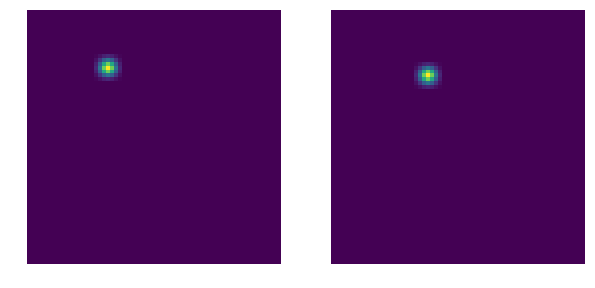

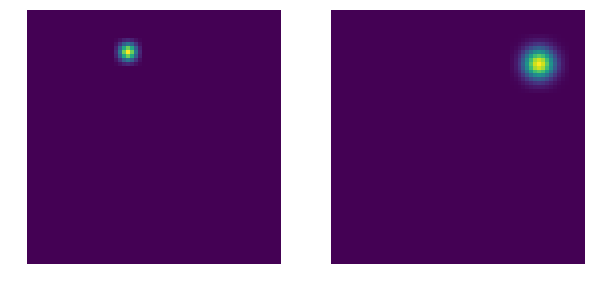

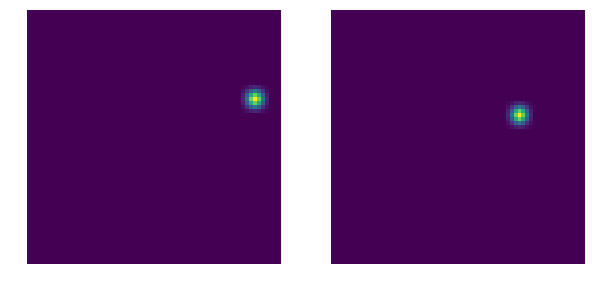

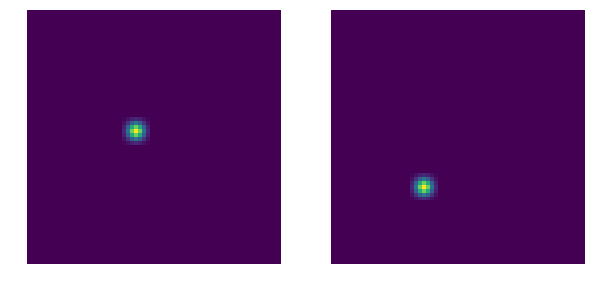

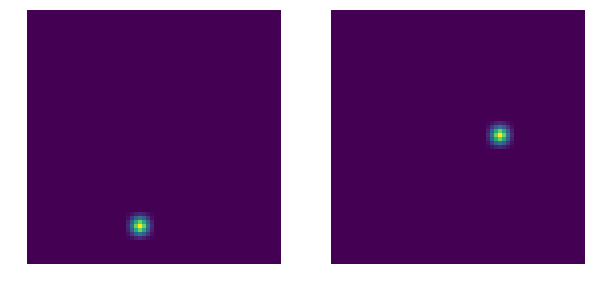

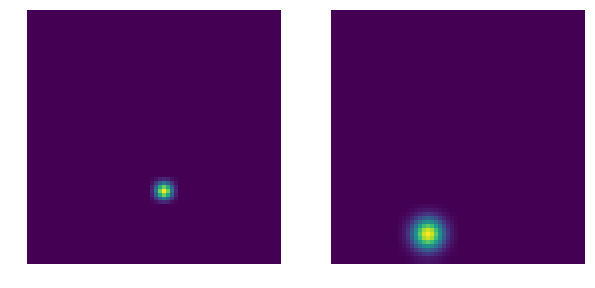

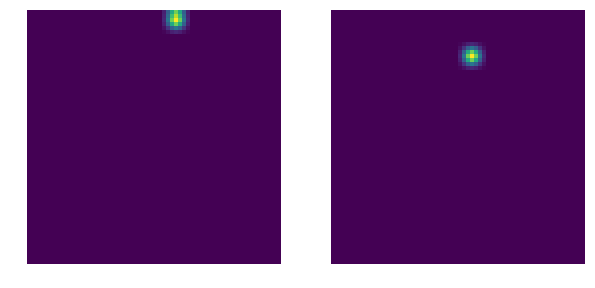

In [42]:
grid_display(res)

In [43]:
recimg = (img * 255 + np.array([[[102.9801,115.9465,122.7717]]])).astype(np.uint8)

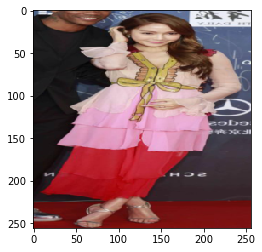

In [45]:
plt.imshow(recimg
          )